In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random, logging
from collections import deque
import tensorflow as tf
from tensorflow.keras import layers
from scipy.optimize import differential_evolution
import random
from tensorflow import keras
import gym
import time
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [2]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [3]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

CONFIG = {
    "mutation_strategies": ['best1bin', 'rand1bin', 'rand2bin', 'currenttobest1bin', 'best1exp', 'rand1exp'],
    "crossover_strategies": ['bin', 'exp'],
    "cma_step_size": 0.3,
    "egt_max_size": 50,
    "dqn_learning_rate": 0.001,
    "max_generations": 100,
    "num_runs": 10,
    "batch_size": 32}

In [15]:
class EGTMemory:
    def __init__(self, max_size=50):
        self.solutions = []
        self.fitness = []
        self.max_size = max_size

    def add_solution(self, solution, fitness):
        if len(self.solutions) < self.max_size:
            self.solutions.append(solution)
            self.fitness.append(fitness)
        else:
            worst_idx = np.argmax(self.fitness)
            if fitness < self.fitness[worst_idx]:
                self.solutions[worst_idx] = solution
                self.fitness[worst_idx] = fitness

    def extract_patterns(self):
        return np.mean(self.solutions, axis=0) if self.solutions else None

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.state_size,)),
            tf.keras.layers.Dense(24, activation='relu'),
            tf.keras.layers.Dense(24, activation='relu'),
            tf.keras.layers.Dense(self.action_size, activation='linear')])
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def select_action(self, state):
        state = np.array(state).reshape(1, -1)
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def train(self, batch_size=32):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state in batch:
            target = reward + self.gamma * np.max(self.model.predict(np.array(next_state).reshape(1, -1), verbose=0))
            target_f = self.model.predict(np.array(state).reshape(1, -1), verbose=0)
            target_f[0][action] = target
            self.model.fit(np.array(state).reshape(1, -1), target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

class AdaptiveEA:
    def __init__(self, objective_function, bounds, generations=50, num_runs=10):
        self.bounds = bounds
        self.objective_function = objective_function
        self.generations = generations
        self.num_runs = num_runs
        self.agent = DQNAgent(state_size=1, action_size=len(CONFIG["mutation_strategies"]))
        self.egt_memory = EGTMemory()

    def evolve(self):
        all_runs_fitness_history = []
        best_solution, best_fitness = None, float('inf')

        for run in range(self.num_runs):
            print(f"Run {run + 1}/{self.num_runs}")
            solution, fitness, fitness_history = self._evolve_single_run()
            all_runs_fitness_history.append(fitness_history)

            if fitness < best_fitness:
                best_solution, best_fitness = solution, fitness

        return best_solution, best_fitness, np.mean(all_runs_fitness_history), np.max(all_runs_fitness_history), np.std(all_runs_fitness_history), all_runs_fitness_history

    def _evolve_single_run(self):
        best_solution, best_fitness = None, float('inf')
        fitness_history = []
        strategies = CONFIG["mutation_strategies"]

        F_values = np.random.uniform(0.4, 0.9, size=len(strategies))
        CR_values = np.random.uniform(0.1, 0.9, size=len(strategies))
        stagnation_counter = 0

        for generation in range(self.generations):
            strategy_idx = self.agent.select_action([generation])
            mutation_strategy = strategies[strategy_idx]

            F = F_values[strategy_idx] + np.random.normal(0, 0.1)
            CR = CR_values[strategy_idx] + np.random.normal(0, 0.1)
            F, CR = np.clip(F, 0.1, 1.0), np.clip(CR, 0.1, 1.0)

            result = differential_evolution(
              self.objective_function,
              bounds=self.bounds,
              strategy=mutation_strategy,
              recombination=CR,
              popsize=20,
              tol=0.01,
              mutation=F,
              maxiter=1,
              disp=False,
              # workers=-1,  # Remove or change to workers=1 for immediate updating
              updating='deferred')

            if result.fun < best_fitness:
                best_fitness = result.fun
                best_solution = result.x
                stagnation_counter = 0
            else:
                stagnation_counter += 1

            if stagnation_counter >= 10:
                F_values = np.clip(F_values + np.random.normal(0, 0.05), 0.1, 1.0)
                stagnation_counter = 0

            self.egt_memory.add_solution(result.x, result.fun)
            fitness_history.append(result.fun)

            if np.random.rand() < 0.1:
                F_values[strategy_idx] = np.clip(F_values[strategy_idx] + np.random.normal(0, 0.02), 0.1, 1.0)
                CR_values[strategy_idx] = np.clip(CR_values[strategy_idx] + np.random.normal(0, 0.02), 0.1, 1.0)

            if generation % 10 == 0:
                pattern = self.egt_memory.extract_patterns()
                if pattern is not None:
                    result.x = pattern

            reward = -result.fun
            next_state = [generation + 1]
            self.agent.memory.append(([generation], strategy_idx, reward, next_state))
            self.agent.train()

        return best_solution, best_fitness, fitness_history

def rastrigin(x):
    return 10 * len(x) + np.sum(x**2 - 10 * np.cos(2 * np.pi * x))

bounds = [(-5.12, 5.12)] * 10
adaptive_ea = AdaptiveEA(rastrigin, bounds, generations=CONFIG["max_generations"], num_runs=CONFIG["num_runs"])
best_solution, best_fitness, mean_fitness, max_fitness, std_fitness, fitness_history = adaptive_ea.evolve()

print("Best Solution:", best_solution)
print("Best Fitness:", best_fitness)
print("Mean Fitness:", mean_fitness)
print("Max Fitness:", max_fitness)
print("Std Fitness:", std_fitness)

Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10
Best Solution: [ 1.98690141e-08  3.86307818e-08  5.89550680e-08 -2.33881171e-08
  1.98900174e-08  9.94958665e-01 -9.94958591e-01 -2.46355835e-08
  9.94958632e-01 -6.72607912e-09]
Best Fitness: 2.9848771712818376
Mean Fitness: 39.17237814377535
Max Fitness: 91.53569682178184
Std Fitness: 13.469583585589191


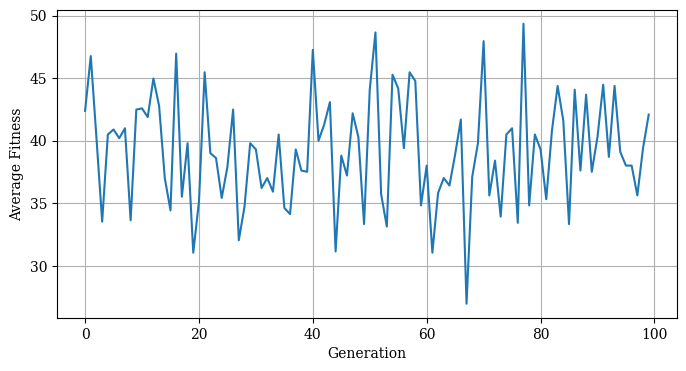

In [16]:
import matplotlib.pyplot as plt

# Calculate the average fitness across all runs for each generation
avg_fitness_history = np.mean(fitness_history, axis=0)

plt.figure(figsize=(8, 4))
plt.plot(avg_fitness_history)
plt.xlabel("Generation")
plt.ylabel("Average Fitness")
# plt.title("Fitness History of Adaptive EA on Rastrigin Function")
plt.grid(True)
plt.show()

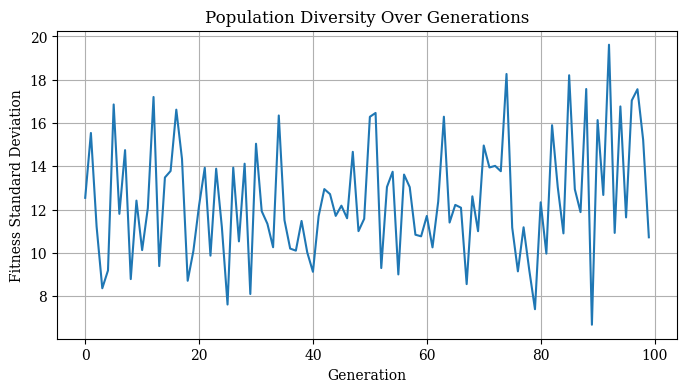

In [18]:
std_fitness = np.std(fitness_history, axis=0)
plt.figure(figsize=(8, 4))
plt.plot(std_fitness)
plt.xlabel("Generation")
plt.ylabel("Fitness Standard Deviation")
plt.title("Population Diversity Over Generations")
plt.grid(True)
plt.show()


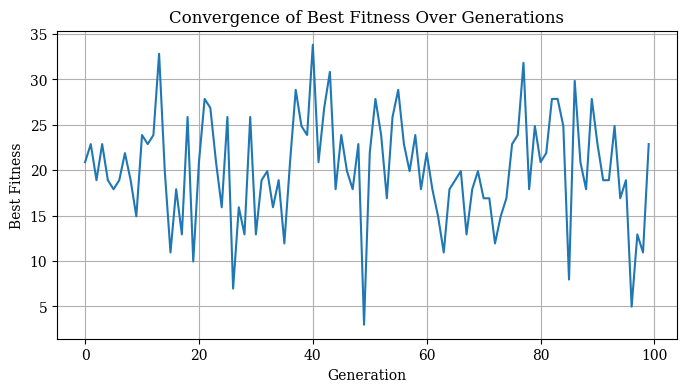

In [19]:
best_fitness = np.min(fitness_history, axis=0)  # Best fitness per generation
plt.figure(figsize=(8, 4))
plt.plot(best_fitness)
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.title("Convergence of Best Fitness Over Generations")
plt.grid(True)
plt.show()


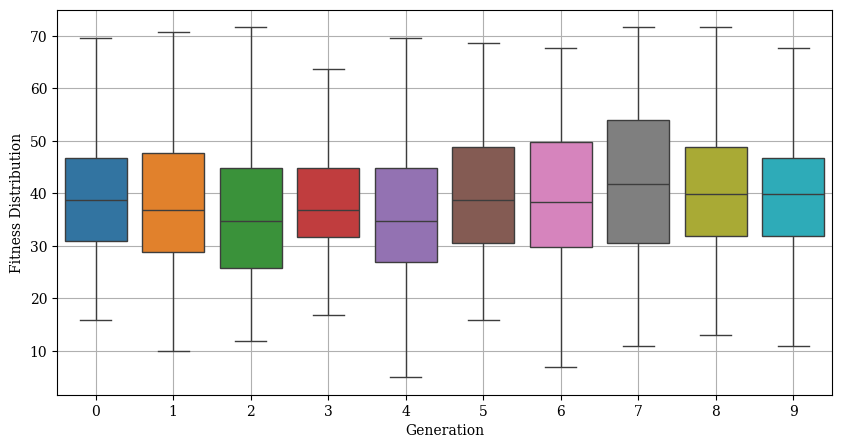

In [21]:
import seaborn as sns
import numpy as np

plt.figure(figsize=(10, 5))
# Convert fitness_history to a NumPy array before transposing
sns.boxplot(data=np.array(fitness_history).T, showfliers=False)  # Transpose to match seaborn format
plt.xlabel("Generation")
plt.ylabel("Fitness Distribution")
plt.grid(True)
plt.show()